In [1]:
from __future__ import print_function
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import json
from tqdm import *
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model, print_summary
from IPython.display import Image
tqdm.monitor_interval = 0
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"

Using TensorFlow backend.


In [2]:
from numpy import linspace
from matplotlib import cm

start = 0.0
stop = 1.0
number_of_lines= 5
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.viridis(x) for x in cm_subsection ]

In [3]:
pad_length = 2500
# best model
LSTM_numb = 512
dr = 0.03
lr = 0.008
b = 64

In [4]:
jsonObj = json.load(open("all_text_sessions.json", "r"))
sessions = {}
for s in jsonObj:
    sessions[s['id']] = s['actions']

In [5]:
import codecs

f = "sc.txt"
syscall_names = []
global actions 
global action_indices
global indices_action
for l in codecs.open(f, "r").readlines():
    syscall_names.append(l.split("\t")[1].replace("\n", "").replace("\r", ""))
# create dictionaries with actions and their indexing for further transformation to
# one-hot-encoding and back
actions = syscall_names
print('total actions:', len(actions))
action_indices = dict((c, i) for i, c in enumerate(actions))
indices_action = dict((i, c) for i, c in enumerate(actions))

total actions: 341


In [6]:
def generic_data(num_sessions = None):
    jsonObj = json.load(open("all_text_sessions.json", "r"))
    seqs = []
    for s in jsonObj:
        seqs.append(s['actions'])

    print('corpus length:', len(seqs))
    
    # cut too long sessions to maximal size of pad_length
    # throw away sessions less than 3 actions long
    input_seqs = []
    next_acts = []
    for seq in seqs:
        if len(seq) > pad_length:
            input_seqs.append(seq[:pad_length-1])
            next_acts.append(seq[pad_length-1])
        if len(seq) <= pad_length and len(seq) > 2:
            pad_len = pad_length - len(seq)
            pad_seq = [None] * pad_len
            pad_seq.extend(seq[:-1])
            input_seqs.append(pad_seq)
            next_acts.append(seq[-1])
    #print('nb inputs:', len(input_seqs))
    
    # transform sequences and labels to one-hot-encoding vectors
    x = []
    y = []
    for i, inp in enumerate(input_seqs):
        vector_seq = np.zeros((len(inp),len(actions)))
        for t, action in enumerate(inp):
            if action is not None:
                vector_seq[t, action_indices[action]] = 1
        x.append(vector_seq)
        vector_label = np.zeros((len(actions)))
        vector_label[action_indices[next_acts[i]]] = 1
        y.append(vector_label)
    
    #taking random num_sessions
    if num_sessions is not None:
        print("Selected data ", num_sessions)
        idx = np.random.randint(len(x), size=num_sessions)
        x = np.asarray(x)
        x = x[idx,:,:]
    
    # separate into training, val and testing parts
    train_size = int(round(len(x)*0.7))
    val_size = int(round(len(x)*0.85))
    x_train = np.asarray(x[:train_size])
    y_train = np.asarray(y[:train_size])
    x_val = np.asarray(x[train_size:val_size])
    y_val = np.asarray(y[train_size:val_size])
    x_test = np.asarray(x[val_size:])
    y_test = np.asarray(y[val_size:])
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = generic_data()

corpus length: 5206


In [8]:
np.random.seed(42)
K.tf.set_random_seed(42)

if os.path.isfile('generic_model_10epochs_adfald.h5'):
    model = load_model('generic_model_10epochs_adfald.h5')
else:
    print('Build generic model...')
    stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                                             verbose=1, mode='auto')

    model = Sequential()
    # have several parameters to choose with meta-parametrization optimization
    model.add(LSTM(LSTM_numb, input_shape=(None, len(actions))))
    model.add(Dropout(dr))
    model.add(Dense(len(actions)))
    model.add(Activation('softmax'))
    optimizer = Adam(lr=lr)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= optimizer)

    hist = model.fit(x=x_train, y=y_train, batch_size=b, epochs=10, verbose=2, callbacks=[stopping], 
                     validation_split=0.15, shuffle=True, initial_epoch=0)

    model.save('generic_model_10epochs_adfald.h5')

In [9]:
model.evaluate(x_test, y_test)

781/781 [==============================] - 43s 55ms/step


[1.6667772545246706, 0.5198463510230622]

In [10]:
def cluster_data(cluster_topic):
    with open('lda_assemblies.json') as f:
        data = json.load(f)
        sessionPFXs = data[cluster_topic]['sessionPFXs']

    # not every log line will have sequence of actions
    seqs = []
    for s in sessions:
        if int(s) in sessionPFXs:
            seqs.append(sessions[s])
    print('corpus length:', len(seqs))    
    
    # cut too long sessions to maximal size of pad_length
    # throw away sessions less than 3 actions long
    input_seqs = []
    next_acts = []
    test_seqs = []
    for seq in seqs:
        if len(seq) > 2:
            test_seqs.append(seq)
        if len(seq) > pad_length:
            input_seqs.append(seq[:pad_length-1])
            next_acts.append(seq[pad_length-1])
        if len(seq) <= pad_length and len(seq) > 2:
            pad_len = pad_length - len(seq)
            pad_seq = [None] * pad_len
            pad_seq.extend(seq[:-1])
            input_seqs.append(pad_seq)
            next_acts.append(seq[-1])
    print('nb inputs:', len(input_seqs))
    
    # transform sequences and labels to one-hot-encoding vectors
    x = []
    y = []
    test_s = []
    for i, inp in enumerate(input_seqs):
        vector_seq = np.zeros((len(inp),len(actions)))
        for t, action in enumerate(inp):
            if action is not None:
                vector_seq[t, action_indices[action]] = 1
        x.append(vector_seq)
        vector_label = np.zeros((len(actions)))
        vector_label[action_indices[next_acts[i]]] = 1
        y.append(vector_label)
        v_t_seq = np.zeros((len(test_seqs[i]),len(actions)))
        for t, action in enumerate(test_seqs[i]):
            if action is not None:
                v_t_seq[t, action_indices[action]] = 1
        test_s.append(v_t_seq)
    test_s = np.asarray(test_s[int(round(len(test_s)*0.85)):])
    test_seqs = np.asarray(test_seqs[int(round(len(test_seqs)*0.85)):])
        
    # separate into training, val and testing parts
    train_size = int(round(len(x)*0.7))
    val_size = int(round(len(x)*0.85))
    x_train = np.asarray(x[:train_size])
    y_train = np.asarray(y[:train_size])
    x_val = np.asarray(x[train_size:val_size])
    y_val = np.asarray(y[train_size:val_size])
    x_test = np.asarray(x[val_size:])
    y_test = np.asarray(y[val_size:])
    
    return x_train, y_train, x_val, y_val, x_test, y_test, test_seqs, test_s

In [11]:
with open('lda_assemblies.json') as f:
    data = json.load(f)
clusters = data.keys()
clusters_datasets = {}
for cluster_topic in clusters:
    print(cluster_topic)
    clusters_datasets[cluster_topic] = cluster_data(cluster_topic)

LDA12Topic11
corpus length: 400
nb inputs: 400
LDA10Topic3
corpus length: 377
nb inputs: 377
LDA12Topic7
corpus length: 110
nb inputs: 110
LDA13Topic6
corpus length: 1454
nb inputs: 1454
LDA11Topic7
corpus length: 285
nb inputs: 285
Others
corpus length: 168
nb inputs: 168
LDA13Topic5
corpus length: 1263
nb inputs: 1263
LDA9Topic8
corpus length: 220
nb inputs: 220
LDA11Topic0
corpus length: 252
nb inputs: 252
LDA6Topic1
corpus length: 644
nb inputs: 644
LDA14Topic7
corpus length: 32
nb inputs: 32


In [12]:
np.random.seed(42)
K.tf.set_random_seed(42)

clusters_models = {}
random_models = {}
clusters_svms = {}
clusters_eval_losses = {}
clusters_eval_perplexities = {}
clusters_eval_accuracies = {}
for cluster_topic in clusters_datasets:
    print(cluster_topic)
    # cluster model
    stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                                         verbose=1, mode='auto')
    cluster_model = Sequential()
    # have several parameters to choose with meta-parametrization optimization
    cluster_model.add(LSTM(LSTM_numb, input_shape=(None, len(actions))))
    cluster_model.add(Dropout(dr))
    cluster_model.add(Dense(len(actions)))
    cluster_model.add(Activation('softmax'))
    optimizer = Adam(lr=lr)

    cluster_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= optimizer)

    c_hist = cluster_model.fit(x=clusters_datasets[cluster_topic][0], y=clusters_datasets[cluster_topic][1], batch_size=b, 
                               epochs=10, verbose=0, callbacks=[stopping], 
                               validation_data=(clusters_datasets[cluster_topic][2], clusters_datasets[cluster_topic][3]), 
                               shuffle=True, initial_epoch=0)
    
    local_eval = cluster_model.evaluate(clusters_datasets[cluster_topic][4], clusters_datasets[cluster_topic][5], verbose=0)
    
    clusters_models[cluster_topic] = cluster_model
    
    # one class SVM
    X_train = np.concatenate((clusters_datasets[cluster_topic][0], clusters_datasets[cluster_topic][2]), axis=0)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

    estimator = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
    estimator.fit(X_train)
    clusters_svms[cluster_topic] = estimator
    
    X_test = np.array(clusters_datasets[cluster_topic][4])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
    preds = estimator.predict(X_test)
    print("Accuracy of cluster identification with SVM: ", "{:.2%}".format(len(np.where(preds == 1)[0])*1.0/len(preds)))
    
    # random subset model
    xg_train, yg_train, xg_val, yg_val, xg_test, yg_test = generic_data(num_sessions = 
                                                                        len(clusters_datasets[cluster_topic][0]) + 
                                                                        len(clusters_datasets[cluster_topic][2]) + 
                                                                        len(clusters_datasets[cluster_topic][4]))

    gen_model = Sequential()
    # have several parameters to choose with meta-parametrization optimization
    gen_model.add(LSTM(LSTM_numb, input_shape=(None, len(actions))))
    gen_model.add(Dropout(dr))
    gen_model.add(Dense(len(actions)))
    gen_model.add(Activation('softmax'))
    optimizer = Adam(lr=lr)

    gen_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= optimizer)

    g_hist = gen_model.fit(x=xg_train, y=yg_train, batch_size=b, epochs=10, verbose=0, 
                           callbacks=[stopping], validation_data=(xg_val, yg_val), shuffle=True, initial_epoch=0)
    
    random_models[cluster_topic] = gen_model
    
    # evaluate
    global_eval = model.evaluate(clusters_datasets[cluster_topic][4], clusters_datasets[cluster_topic][5], verbose=0)
    random_eval = gen_model.evaluate(clusters_datasets[cluster_topic][4], clusters_datasets[cluster_topic][5], verbose=0)
    clusters_eval_losses[cluster_topic] = [local_eval[0], global_eval[0], random_eval[0]]
    clusters_eval_accuracies[cluster_topic] = [local_eval[1], global_eval[1], random_eval[1]]

LDA12Topic11
Accuracy of cluster identification with SVM:  8.33%
corpus length: 5206
Selected data  400
LDA10Topic3
Accuracy of cluster identification with SVM:  49.12%
corpus length: 5206
Selected data  377
LDA12Topic7
Accuracy of cluster identification with SVM:  75.00%
corpus length: 5206
Selected data  110
LDA13Topic6
Accuracy of cluster identification with SVM:  80.28%
corpus length: 5206
Selected data  1454
LDA11Topic7
Accuracy of cluster identification with SVM:  11.63%
corpus length: 5206
Selected data  285
LDA13Topic5
Accuracy of cluster identification with SVM:  30.69%
corpus length: 5206
Selected data  1263
Others
Accuracy of cluster identification with SVM:  8.00%
corpus length: 5206
Selected data  168
LDA11Topic0
Accuracy of cluster identification with SVM:  0.00%
corpus length: 5206
Selected data  252
LDA6Topic1
Accuracy of cluster identification with SVM:  6.19%
corpus length: 5206
Selected data  644
LDA14Topic7
Accuracy of cluster identification with SVM:  0.00%
corpus 

In [13]:
import operator

cluster_lengths = {}
for cluster in clusters_datasets:
    cluster_lengths[cluster] = len(clusters_datasets[cluster][0])
ordered_cluster_lengths = sorted(cluster_lengths.items(), key=operator.itemgetter(1))
ordered_by_lengths = [e[0] for e in ordered_cluster_lengths]

In [14]:
import pickle

if not os.path.isfile("assemblies_eval_losses_adfald"):
    pickle.dump(clusters_eval_losses, open("assemblies_eval_losses_adfald", "wb"))
    pickle.dump(clusters_eval_accuracies, open("assemblies_eval_accuracies_adfald", "wb"))

In [15]:
cluster_names = []
for i in range(len(ordered_by_lengths)):
    cluster_names.append("Cluster" + str(i+1))

In [16]:
losses_gl = []
losses_cl = []
losses_rn = []
for c in ordered_by_lengths:
    losses_gl.append(clusters_eval_losses[c][1])
    losses_rn.append(clusters_eval_losses[c][2])
    losses_cl.append(clusters_eval_losses[c][0])
    
fig, ax = plt.subplots()
plt.scatter(range(len(ordered_by_lengths)), losses_gl, c=[colors[0]], marker='s', alpha=0.7, label='Global model')
plt.scatter(range(len(ordered_by_lengths)), losses_cl, c=[colors[1]], marker='*', alpha=0.7, label='Cluster model')
plt.scatter(range(len(ordered_by_lengths)), losses_rn, c=[colors[2]], alpha=0.7, label='Global model (cluster size)')
ax.set_xticks(np.arange(len(ordered_by_lengths)))
ax.set_xticklabels(cluster_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Loss")
plt.legend()
plt.show()

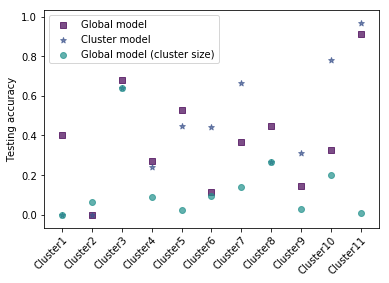

In [17]:
acc_gl = []
acc_cl = []
acc_rn = []
for c in ordered_by_lengths:
    acc_gl.append(clusters_eval_accuracies[c][1])
    acc_rn.append(clusters_eval_accuracies[c][2])
    acc_cl.append(clusters_eval_accuracies[c][0])
    
fig, ax = plt.subplots()
plt.scatter(range(len(ordered_by_lengths)), acc_gl, c=[colors[0]], marker='s', alpha=0.7, label='Global model')
plt.scatter(range(len(ordered_by_lengths)), acc_cl, c=[colors[1]], marker='*', alpha=0.7, label='Cluster model')
plt.scatter(range(len(ordered_by_lengths)), acc_rn, c=[colors[2]], alpha=0.7, label='Global model (cluster size)')
ax.set_xticks(np.arange(len(ordered_by_lengths)))
ax.set_xticklabels(cluster_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Testing accuracy")
plt.legend()
plt.show()

In [18]:
accuracies = []
own_vs_avg = []
for cluster_topic in ordered_by_lengths:
    print(cluster_topic)
    accuracies.append([])
    own_vs_avg.append([0,0])
    for test in ordered_by_lengths:
        ac = clusters_models[cluster_topic].evaluate(clusters_datasets[test][4], clusters_datasets[test][5], verbose=0)[1]
        accuracies[-1].append(ac)
        if cluster_topic == test:
            own_vs_avg[-1][0] = ac
        else:
            own_vs_avg[-1][1] += ac
    own_vs_avg[-1][1] /= 10.0

LDA14Topic7
LDA12Topic7
Others
LDA9Topic8
LDA11Topic0
LDA11Topic7
LDA10Topic3
LDA12Topic11
LDA6Topic1
LDA13Topic5
LDA13Topic6


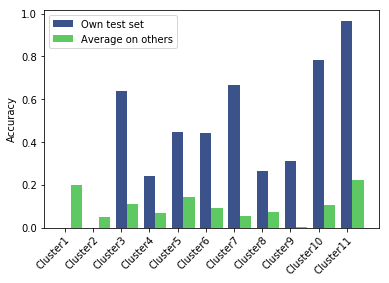

In [19]:
x = np.arange(len(cluster_names))
plt.bar(x, [e[0] for e in own_vs_avg],width=0.4,color=colors[1],align='center', label='Own test set')
plt.bar(x+0.4, [e[1] for e in own_vs_avg],width=0.4,color=colors[3],align='center', label='Average on others')
plt.legend()
plt.ylabel("Accuracy")
plt.xticks(x, cluster_names, rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

In [20]:
import pickle

if not os.path.isfile("own_vs_avg_accuracies_assemblies_adfald"):
    pickle.dump(own_vs_avg, open("own_vs_avg_accuracies_assemblies_adfald", "wb"))

In [23]:
jsonObj = json.load(open("attack_text_sessions.json", "r"))
attack_sessions = []
for s in jsonObj:
    attack_sessions.append(s['actions']) 

# cut too long sessions to maximal size of pad_length
# throw away sessions less than 3 actions long
attack_test_seqs = []
for seq in attack_sessions:
    if len(seq) > 2:
        attack_test_seqs.append(seq)
print('nb inputs:', len(attack_test_seqs))

# transform sequences and labels to one-hot-encoding vectors
attack_test_s = []
for i, inp in enumerate(attack_test_seqs):
    v_t_seq = np.zeros((len(attack_test_seqs[i]),len(actions)))
    for t, action in enumerate(attack_test_seqs[i]):
        if action is not None:
            v_t_seq[t, action_indices[action]] = 1
    attack_test_s.append(v_t_seq)

nb inputs: 746


In [ ]:
from collections import Counter

attack_predictions = []
for i in tqdm(range(len(attack_test_s))):
    session = attack_test_s[i]
    t_session = attack_test_seqs[i]
    svm_predictions = []
    #gl_losses = []
    #gl_scores = []
    max_clusters = []
    max_cluster_scores = []
    max_losses = []
    #first_clusters = []
    #smart_pred_scores = []
    #smart_pred_losses = []
    #pred_cl = None
    to_eval = min([100, len(session)])
    for j in range(to_eval):
        if j >= 4:
            cur_evaluation = session[:j]
            cur_pred = session[j]
            if len(cur_evaluation) < pad_length-1:
                pad_len = pad_length-1 - len(cur_evaluation)
                pad_seq = np.zeros((pad_len, len(actions))).tolist()
                pad_seq.extend(cur_evaluation)
                cur_evaluation = np.array(pad_seq)
            if len(cur_evaluation) > pad_length-1:
                cur_evaluation = np.array(cur_evaluation[-(pad_length-1):])

            #gl_losses.append(model.evaluate(np.array([cur_evaluation]), np.array([cur_pred]), verbose=0)[0])
            #gl_scores.append(model.predict(np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])

            max_score = -1
            max_cluster = ordered_by_lengths[0]
            for cl in clusters_svms:
                cl_score = clusters_svms[cl].decision_function(np.reshape(cur_evaluation, 
                                                                    (1, cur_evaluation.shape[0]*cur_evaluation.shape[1])))[0][0]
                if cl_score > max_score:
                    max_score = cl_score
                    max_cluster = cl
            #if j < 15:
            #    first_clusters.append(max_cluster)
            #elif pred_cl is None:
            #    pred_cl = Counter(first_clusters)
            #    pred_cl = pred_cl.most_common(1)[0][0]
            max_clusters.append(max_score)
            max_cluster_scores.append(clusters_models[max_cluster].predict(
                np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])  
            max_losses.append(clusters_models[max_cluster].evaluate(np.array([cur_evaluation]), 
                                                                    np.array([cur_pred]), verbose=0)[0])
            #if j < 15:
            #    smart_pred_losses.append(max_losses[-1])
            #    smart_pred_scores.append(max_cluster_scores[-1])
            #else:
            #    smart_pred_scores.append(clusters_models[pred_cl].predict(
            #        np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])  
            #    smart_pred_losses.append(clusters_models[pred_cl].evaluate(np.array([cur_evaluation]), 
            #                                                        np.array([cur_pred]), verbose=0)[0])
    attack_predictions.append([#gl_losses, gl_scores, 
                                max_clusters, max_cluster_scores, max_losses
                               #, smart_pred_scores, smart_pred_losses
                              ])

In [ ]:
if not os.path.isfile("attack_predictions_assemblies_adfald"):
    pickle.dump(attack_predictions, open("attack_predictions_assemblies_adfald", "wb"))

In [14]:
predictions = {}
for test_cl in ordered_by_lengths:
    print(test_cl)
    predictions[test_cl] = []
    local_model = clusters_models[test_cl]
    rnd_model = random_models[test_cl]
    for i in tqdm(range(len(clusters_datasets[test_cl][6]))):
        session = clusters_datasets[test_cl][7][i]
        session = np.array(session)
        t_session = clusters_datasets[test_cl][6][i]
        svm_predictions = []
        gl_losses = []
        gl_scores = []
        max_clusters = []
        max_cluster_scores = []
        max_losses = []
        #first_clusters = []
        #smart_pred_scores = []
        #smart_pred_losses = []
        #pred_cl = None
        to_eval = min([100, len(session)])
        for j in range(to_eval):
            if j >= 4:
                cur_evaluation = session[:j]
                cur_pred = session[j]
                if len(cur_evaluation) < pad_length-1:
                    pad_len = pad_length-1 - len(cur_evaluation)
                    pad_seq = np.zeros((pad_len, len(actions))).tolist()
                    pad_seq.extend(cur_evaluation)
                    cur_evaluation = np.array(pad_seq)
                if len(cur_evaluation) > pad_length-1:
                    cur_evaluation = np.array(cur_evaluation[-(pad_length-1):])

                gl_losses.append(model.evaluate(np.array([cur_evaluation]), np.array([cur_pred]), verbose=0)[0])
                gl_scores.append(model.predict(np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])

                max_score = -1
                max_cluster = ordered_by_lengths[0]
                for cl in clusters_svms:
                    cl_score = clusters_svms[cl].decision_function(np.reshape(cur_evaluation, 
                                                                        (1, cur_evaluation.shape[0]*cur_evaluation.shape[1])))[0][0]
                    if cl_score > max_score:
                        max_score = cl_score
                        max_cluster = cl
                #if j < 15:
                #    first_clusters.append(max_cluster)
                #elif pred_cl is None:
                #    pred_cl = Counter(first_clusters)
                #    pred_cl = pred_cl.most_common(1)[0][0]
                max_clusters.append(max_score)
                max_cluster_scores.append(clusters_models[max_cluster].predict(
                    np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])  
                max_losses.append(clusters_models[max_cluster].evaluate(np.array([cur_evaluation]), 
                                                                        np.array([cur_pred]), verbose=0)[0])
                #if j < 15:
                #    smart_pred_losses.append(max_losses[-1])
                #    smart_pred_scores.append(max_cluster_scores[-1])
                #else:
                #    smart_pred_scores.append(clusters_models[pred_cl].predict(
                #        np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])  
                #    smart_pred_losses.append(clusters_models[pred_cl].evaluate(np.array([cur_evaluation]), 
                #                                                        np.array([cur_pred]), verbose=0)[0])
        predictions[test_cl].append([gl_losses, gl_scores, 
                                    max_clusters, max_cluster_scores, max_losses
                                     #, smart_pred_scores, smart_pred_losses
                                    ])

  0%|          | 0/5 [00:00<?, ?it/s]

LDA14Topic7


  0%|          | 0/16 [00:00<?, ?it/s]

LDA12Topic7


  0%|          | 0/25 [00:00<?, ?it/s]

Others


  0%|          | 0/33 [00:00<?, ?it/s]

LDA9Topic8


  0%|          | 0/38 [00:00<?, ?it/s]

LDA11Topic0


  0%|          | 0/43 [00:00<?, ?it/s]

LDA11Topic7


  0%|          | 0/57 [00:00<?, ?it/s]

LDA10Topic3


  0%|          | 0/60 [00:00<?, ?it/s]

LDA12Topic11


  0%|          | 0/97 [00:00<?, ?it/s]

LDA6Topic1


  0%|          | 0/189 [00:00<?, ?it/s]

LDA13Topic5


  0%|          | 0/218 [00:00<?, ?it/s]

LDA13Topic6


100%|██████████| 218/218 [33:44:10<00:00, 557.11s/it]   


In [16]:
import pickle
if not os.path.isfile("predictions_assemblies_adfald"):
    pickle.dump(predictions, open("predictions_assemblies_adfald", "wb"))